In [1]:
# Basic setup
import sys, platform
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

print("Python:", sys.version)
print("Platform:", platform.platform())
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)

Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.26100-SP0
NumPy: 2.2.6
Pandas: 2.3.1


Using a single category makes it very likely we’ll get a bigram containing a top unigram (e.g., “space” → “space shuttle”).
You can switch to multiple categories later if you want.

In [2]:
categories = ['sci.space']  # try ['sci.space', 'sci.med'] to compare domains
data = fetch_20newsgroups(
    subset='train',
    categories=categories,
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42
)
docs = [d for d in data.data if d and d.strip()]
len(docs), categories

(577, ['sci.space'])

Let us build a TDM and print the top 10 corpus words

In [3]:
uni_vec = CountVectorizer(ngram_range=(1,1), stop_words='english', min_df=2)
X_uni = uni_vec.fit_transform(docs)  # shape: (n_docs, n_unigrams)
uni_terms = np.array(uni_vec.get_feature_names_out())

uni_counts = np.asarray(X_uni.sum(axis=0)).ravel()
top10_uni_idx = np.argsort(uni_counts)[::-1][:10]
top10_uni_terms = uni_terms[top10_uni_idx]
top10_uni_counts = uni_counts[top10_uni_idx]

tdm_uni_top10 = pd.DataFrame(
    X_uni[:, top10_uni_idx].toarray(),
    columns=top10_uni_terms
)
print("Top-10 unigrams:\n", pd.DataFrame({
    "term": top10_uni_terms,
    "total_count": top10_uni_counts
}).reset_index(drop=True))
tdm_uni_top10.head()


Top-10 unigrams:
       term  total_count
0    space          989
1     nasa          374
2   launch          267
3    earth          222
4     like          222
5     data          216
6    orbit          201
7     time          197
8  shuttle          192
9     just          189


,space,nasa,launch,earth,like,data,orbit,time,shuttle,just
0,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1


Let us build bi-gram TDM and print top 10 bi-grams

In [4]:
bi_vec = CountVectorizer(ngram_range=(2,2), stop_words='english', min_df=2)
X_bi = bi_vec.fit_transform(docs)   # shape: (n_docs, n_bigrams)
bi_terms = np.array(bi_vec.get_feature_names_out())

bi_counts = np.asarray(X_bi.sum(axis=0)).ravel()
top10_bi_idx = np.argsort(bi_counts)[::-1][:10]
top10_bi_terms = bi_terms[top10_bi_idx]
top10_bi_counts = bi_counts[top10_bi_idx]

tdm_bi_top10 = pd.DataFrame(
    X_bi[:, top10_bi_idx].toarray(),
    columns=top10_bi_terms
)
print("Top-10 bigrams:\n", pd.DataFrame({
    "bigram": top10_bi_terms,
    "total_count": top10_bi_counts
}).reset_index(drop=True))
tdm_bi_top10.head()


Top-10 bigrams:
              bigram  total_count
0          nasa gov           72
1     space station           68
2     space shuttle           65
3         sci space           58
4     anonymous ftp           38
5  commercial space           32
6    remote sensing           32
7     washington dc           30
8    national space           28
9         gamma ray           26


,nasa gov,space station,space shuttle,sci space,anonymous ftp,commercial space,remote sensing,washington dc,national space,gamma ray
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


Let us compare unigram and bi-gram and their embeddings.  preferably among top-10; else widen search

In [5]:
def find_containing_bigram(unigram, candidate_bigrams):
    token = unigram.strip()
    # Return first bigram that contains the token as a whole word
    for bg in candidate_bigrams:
        w1, w2 = bg.split()
        if token == w1 or token == w2:
            return bg
    return None

# Prefer a unigram that's likely domain-specific (e.g., 'space') if present
preferred = None
for candidate in ["space", "nasa", "orbit", "shuttle", "earth", "station"]:
    if candidate in set(top10_uni_terms):
        preferred = candidate
        break

# Fallback to the most frequent unigram if no preferred appears
unigram_for_demo = preferred or top10_uni_terms[0]
print("Chosen unigram:", unigram_for_demo)

# First try among top-10 bigrams
bigram_for_demo = find_containing_bigram(unigram_for_demo, top10_bi_terms)

# If not found, search the top-200 bigrams
if bigram_for_demo is None:
    topK = 200 if len(bi_terms) >= 200 else len(bi_terms)
    topK_idx = np.argsort(bi_counts)[::-1][:topK]
    topK_terms = bi_terms[topK_idx]
    bigram_for_demo = find_containing_bigram(unigram_for_demo, topK_terms)

print("Matched bigram:", bigram_for_demo)

# Extract their "embeddings" (column vectors over documents)
uni_col = X_uni[:, uni_vec.vocabulary_.get(unigram_for_demo)] if unigram_for_demo in uni_vec.vocabulary_ else None
bi_col  = X_bi[:,  bi_vec.vocabulary_.get(bigram_for_demo)]   if bigram_for_demo  in bi_vec.vocabulary_ else None

assert uni_col is not None and bi_col is not None, "Could not find matching columns. Try rerunning with different categories."

uni_vec_col = np.asarray(uni_col.toarray()).ravel()
bi_vec_col  = np.asarray(bi_col.toarray()).ravel()

# Basic stats to show 'alteration' of the representation
df_uni = (uni_vec_col > 0).sum()
df_bi  = (bi_vec_col  > 0).sum()
cos_sim = float(cosine_similarity([uni_vec_col], [bi_vec_col])[0,0])

summary = pd.DataFrame({
    "feature": [unigram_for_demo, bigram_for_demo],
    "total_count": [uni_vec_col.sum(), bi_vec_col.sum()],
    "doc_frequency (#docs with >=1)": [df_uni, df_bi]
})
print("\nUnigram vs Bigram summary:")
display(summary)
print(f"Cosine similarity between unigram and bigram vectors: {cos_sim:.4f}")

# Show a small side-by-side sample across first 20 docs
compare_df = pd.DataFrame({
    f"unigram:{unigram_for_demo}": uni_vec_col[:20],
    f"bigram:{bigram_for_demo}": bi_vec_col[:20],
})
compare_df.index.name = "doc_id (sample)"
compare_df


Chosen unigram: space
Matched bigram: space station

Unigram vs Bigram summary:


,feature,total_count,doc_frequency (#docs with >=1)
0,space,989,214
1,space station,68,34


Cosine similarity between unigram and bigram vectors: 0.2920


,unigram:space,bigram:space station
doc_id (sample),,
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
5,0,0
6,1,0
7,0,0
8,0,0


Visual: distribution comparison

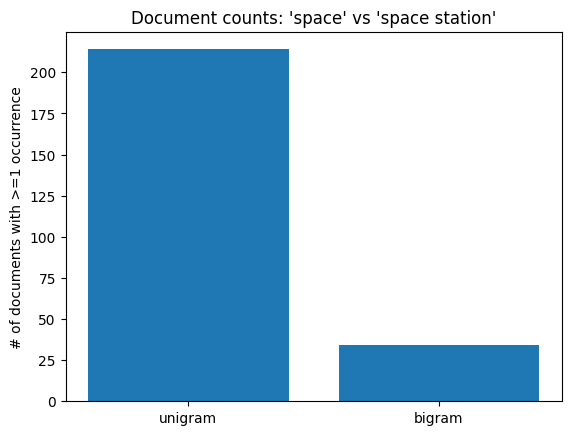

In [6]:
# Compare how widely the unigram vs bigram fires across the corpus
plt.figure()
plt.title(f"Document counts: '{unigram_for_demo}' vs '{bigram_for_demo}'")
plt.bar(["unigram", "bigram"], [df_uni, df_bi])
plt.ylabel("# of documents with >=1 occurrence")
plt.show()
